# Redes LSTM con Keras para Procesamiento Secuencial de Texto

**Materiales desarrollados por Matías Barreto, 2025**

**Tecnicatura en Ciencia de Datos - IFTS**

**Asignatura:** Procesamiento de Lenguaje Natural

---

## Introducción

Hasta ahora trabajamos con **Bag of Words**: representamos texto ignorando el orden de las palabras. Esto tiene una limitación crítica: "No me gusta" y "Me gusta no" tienen la misma representación, pero significados opuestos.

Las **redes recurrentes** (RNN) procesan texto como **secuencia ordenada**, capturando contexto y dependencias temporales. Las **LSTM** (Long Short-Term Memory) son una variante de RNN diseñada para recordar información relevante a largo plazo.

### ¿Qué cambia con LSTM?

1. **Procesa secuencialmente**: Palabra por palabra, manteniendo memoria del contexto
2. **Captura orden**: "No me gusta" ≠ "Me gusta no"
3. **Memoria selectiva**: Recuerda información relevante, olvida ruido
4. **Dependencias largas**: Puede relacionar palabras distantes en el texto

### Objetivos de aprendizaje

1. Comprender la arquitectura de redes recurrentes (RNN/LSTM)
2. Procesar texto como secuencias con Tokenizer de Keras
3. Aplicar padding para uniformizar longitudes
4. Implementar embeddings aprendidos (vs. pre-entrenados)
5. Entrenar una LSTM para clasificación de sentimientos
6. Comparar rendimiento con MLP feedforward

### ¿Por qué Keras?

Keras (ahora integrado en TensorFlow) es:
- Más simple que PyTorch para prototipado rápido
- API de alto nivel, menos código
- Excelente para RNN/LSTM (Sequential API muy clara)
- Ampliamente usado en industria

**Nota:** En el ecosistema de transformers (HuggingFace) se usa principalmente PyTorch, pero conocer ambos frameworks es valioso.

---

## 1. Instalación e Importación de Librerías

En Google Colab, TensorFlow/Keras ya viene instalado.

In [1]:
# Si necesitás instalar TensorFlow (descomentá)
# !pip install tensorflow

# NumPy para operaciones numéricas
import numpy as np

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras

# Keras Sequential: API para apilar capas
from tensorflow.keras.models import Sequential

# Capas de Keras
# Embedding: Capa que aprende representaciones vectoriales de palabras
# LSTM: Capa recurrente con memoria a largo plazo
# Dense: Capa fully connected (como en MLP)
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Preprocesamiento de texto
# Tokenizer: Convierte texto en secuencias de enteros
# pad_sequences: Uniformiza longitud de secuencias
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Matplotlib para visualizaciones
import matplotlib.pyplot as plt

# Fijamos semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow versión: {tf.__version__}")
print(f"Keras versión: {keras.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow versión: 2.19.0
Keras versión: 3.10.0
GPU disponible: True


---

## 2. Dataset: Análisis de Sentimiento en Español Rioplatense

Usamos el mismo corpus que en el notebook de PyTorch para comparar resultados.

In [2]:
# Corpus de frases en español rioplatense
# Etiqueta: 1 = Positivo, 0 = Negativo
frases = [
    # Positivas
    "La verdad, este lugar está bárbaro. Muy recomendable.",
    "Qué buena onda la atención, volvería sin dudarlo.",
    "Me encantó la comida, aunque la música estaba muy fuerte.",
    "Todo excelente. Atención de diez.",
    "Muy conforme con el resultado final.",
    "Superó mis expectativas, gracias.",
    "El mejor asado que probé en mucho tiempo.",
    "Excelente relación precio-calidad, muy recomendable.",
    "La atención fue impecable, muy atentos.",
    "Me gustó mucho el ambiente tranquilo.",

    # Negativas
    "Una porquería de servicio, nunca más vuelvo.",
    "El envío fue lento y el producto llegó dañado. Qué desastre.",
    "Qué estafa, me arrepiento de haber comprado.",
    "No me gustó para nada la experiencia.",
    "No lo recomiendo, mala calidad.",
    "Malísima atención, el mozo tenía mala onda.",
    "Tardaron dos horas en entregar, llegó todo frío.",
    "Me cobraron de más y encima se hicieron los giles.",
    "La carne estaba pasada, casi no se podía comer.",
    "Pésima experiencia, no vuelvo más."
]

# Etiquetas: 1=positivo, 0=negativo
etiquetas = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 10 positivas
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # 10 negativas

print(f"Corpus: {len(frases)} frases")
print(f"Distribución: {np.bincount(etiquetas)}")
print(f"\nEjemplos:")
print(f"[+] {frases[0]}")
print(f"[-] {frases[10]}")

Corpus: 20 frases
Distribución: [10 10]

Ejemplos:
[+] La verdad, este lugar está bárbaro. Muy recomendable.
[-] Una porquería de servicio, nunca más vuelvo.


---

## 3. Tokenización: De Texto a Secuencias de Enteros

El `Tokenizer` de Keras:
1. Construye un **vocabulario** (palabra → índice)
2. Convierte cada **texto en secuencia de enteros**
3. Maneja palabras fuera del vocabulario (OOV - Out Of Vocabulary)

### Ejemplo:
```
Vocabulario: {"me": 1, "gusta": 2, "no": 3, "comida": 4}

Texto: "Me gusta la comida" → [1, 2, 5, 4]  # 5 = OOV token para "la"
```

In [3]:
# Configuración del tokenizer
# oov_token: Token especial para palabras no vistas (Out Of Vocabulary)
tokenizer = Tokenizer(oov_token="<OOV>")

# Paso 1: Construir el vocabulario a partir de las frases
# fit_on_texts() analiza el corpus y crea el mapeo palabra→índice
tokenizer.fit_on_texts(frases)

# Información del vocabulario
vocab_size = len(tokenizer.word_index) + 1  # +1 para el índice 0 (padding)
print(f"Tamaño del vocabulario: {vocab_size} palabras")
print(f"\nPrimeras 15 palabras del vocabulario:")
print(dict(list(tokenizer.word_index.items())[:15]))

# Paso 2: Convertir textos a secuencias de enteros
# texts_to_sequences() reemplaza cada palabra por su índice
secuencias = tokenizer.texts_to_sequences(frases)

print(f"\nEjemplo de secuencia:")
print(f"Texto original: '{frases[0]}'")
print(f"Secuencia: {secuencias[0]}")
print(f"Longitud: {len(secuencias[0])} tokens")

# Reconstrucción inversa (para verificar)
# word_index invertido: índice → palabra
index_word = {idx: word for word, idx in tokenizer.word_index.items()}
reconstruido = ' '.join([index_word.get(idx, '<OOV>') for idx in secuencias[0]])
print(f"Reconstrucción: '{reconstruido}'")

Tamaño del vocabulario: 97 palabras

Primeras 15 palabras del vocabulario:
{'<OOV>': 1, 'la': 2, 'el': 3, 'muy': 4, 'me': 5, 'atención': 6, 'de': 7, 'no': 8, 'qué': 9, 'más': 10, 'recomendable': 11, 'onda': 12, 'estaba': 13, 'todo': 14, 'excelente': 15}

Ejemplo de secuencia:
Texto original: 'La verdad, este lugar está bárbaro. Muy recomendable.'
Secuencia: [2, 27, 28, 29, 30, 31, 4, 11]
Longitud: 8 tokens
Reconstrucción: 'la verdad este lugar está bárbaro muy recomendable'


---

## 4. Padding: Uniformizando Longitudes

Las redes neuronales requieren inputs de tamaño fijo, pero las frases tienen longitudes variables. **Padding** rellena secuencias cortas con ceros.

### Estrategias de padding:

**Pre-padding** (por defecto):
```
[5, 2, 8, 1] → [0, 0, 0, 0, 0, 0, 5, 2, 8, 1]  # Ceros al inicio
```

**Post-padding**:
```
[5, 2, 8, 1] → [5, 2, 8, 1, 0, 0, 0, 0, 0, 0]  # Ceros al final
```

**¿Cuál usar?**
- **Pre-padding**: Mejor para RNN/LSTM (las palabras relevantes están al final)
- **Post-padding**: Mejor para Transformers

In [4]:
# Analizamos las longitudes de las secuencias
longitudes = [len(seq) for seq in secuencias]
print("Estadísticas de longitudes:")
print(f"Mínima: {min(longitudes)} tokens")
print(f"Máxima: {max(longitudes)} tokens")
print(f"Promedio: {np.mean(longitudes):.1f} tokens")

# Definimos la longitud máxima (maxlen)
# Opción 1: Usar el máximo observado
maxlen = max(longitudes)
print(f"\nUsaremos maxlen = {maxlen}")

# Aplicamos padding
# padding='post': Agrega ceros al final (recomendado para LSTM)
# truncating='post': Si una secuencia es > maxlen, trunca al final
X = pad_sequences(secuencias, maxlen=maxlen, padding='post', truncating='post')

print(f"\nForma de X: {X.shape} (muestras x tokens)")
print(f"\nEjemplo de secuencia con padding:")
print(f"Original ({len(secuencias[0])} tokens): {secuencias[0]}")
print(f"Con padding ({maxlen} tokens): {X[0]}")
print(f"\nNota: Los ceros al final son padding (relleno).")

# Convertimos etiquetas a formato adecuado
y = etiquetas.astype(np.float32)

Estadísticas de longitudes:
Mínima: 4 tokens
Máxima: 11 tokens
Promedio: 7.2 tokens

Usaremos maxlen = 11

Forma de X: (20, 11) (muestras x tokens)

Ejemplo de secuencia con padding:
Original (8 tokens): [2, 27, 28, 29, 30, 31, 4, 11]
Con padding (11 tokens): [ 2 27 28 29 30 31  4 11  0  0  0]

Nota: Los ceros al final son padding (relleno).


---

## 5. Embeddings: Representaciones Vectoriales de Palabras

### ¿Qué son los embeddings?

Son **representaciones vectoriales densas** de palabras en un espacio continuo de baja dimensión (típicamente 50-300 dimensiones).

### Ventajas sobre one-hot encoding:

**One-hot** (vocabulario de 10,000 palabras):
```
"gato" → [0, 0, 1, 0, 0, ..., 0]  # Vector de 10,000 elementos
"perro" → [0, 1, 0, 0, 0, ..., 0]
```
- Muy disperso (sparse)
- No captura similitud semántica
- Ineficiente computacionalmente

**Embeddings** (dimensión 16):
```
"gato"  → [0.2, -0.5, 0.8, 0.1, ..., -0.3]  # Vector de 16 elementos
"perro" → [0.3, -0.4, 0.7, 0.2, ..., -0.2]  # Similar a "gato"
"casa"  → [-0.8, 0.6, -0.1, 0.9, ..., 0.5]  # Diferente
```
- Denso (compact)
- Captura relaciones semánticas
- Palabras similares tienen vectores similares

### Embeddings aprendidos vs. pre-entrenados:

**Aprendidos (lo que haremos aquí):**
- Se inicializan aleatoriamente
- Se ajustan durante el entrenamiento
- Específicos para nuestra tarea
- Requieren datos suficientes

**Pre-entrenados (Word2Vec, GloVe, FastText):**
- Entrenados en corpus masivos (Wikipedia, Common Crawl)
- Capturan conocimiento lingüístico general
- Útiles con pocos datos
- Los vieron en módulos anteriores del curso

---

## 6. Arquitectura LSTM: Conceptos Fundamentales

### RNN Simple (Recurrent Neural Network)

```
t=1:  x₁ → [RNN] → h₁
              ↓
t=2:  x₂ → [RNN] → h₂
              ↓
t=3:  x₃ → [RNN] → h₃ → output
```

Cada paso recibe:
- Input actual: $x_t$
- Hidden state anterior: $h_{t-1}$

Y produce:
- Nuevo hidden state: $h_t = tanh(W_x x_t + W_h h_{t-1} + b)$

### Problema de las RNN simples: Vanishing Gradient

En secuencias largas, el gradiente se propaga multiplicativamente:
$$\frac{\partial L}{\partial h_1} = \frac{\partial L}{\partial h_T} \cdot \frac{\partial h_T}{\partial h_{T-1}} \cdot ... \cdot \frac{\partial h_2}{\partial h_1}$$

Si cada derivada parcial < 1, el producto tiende a 0 (vanishing gradient).

**Consecuencia:** La RNN "olvida" información temprana, no puede capturar dependencias largas.

### LSTM (Long Short-Term Memory)

LSTM resuelve esto con **celdas de memoria** y **compuertas** (gates):

**Componentes de una celda LSTM:**
1. **Forget gate** (f): ¿Qué información olvidar de la memoria?
2. **Input gate** (i): ¿Qué información nueva agregar?
3. **Cell state** (C): Memoria a largo plazo
4. **Output gate** (o): ¿Qué información exponer?

**Fórmulas (simplificadas):**
```
f_t = σ(W_f · [h_{t-1}, x_t] + b_f)    # Forget gate
i_t = σ(W_i · [h_{t-1}, x_t] + b_i)    # Input gate
C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C) # Candidate values
C_t = f_t * C_{t-1} + i_t * C̃_t        # Update cell state
o_t = σ(W_o · [h_{t-1}, x_t] + b_o)    # Output gate
h_t = o_t * tanh(C_t)                   # Hidden state
```

**Intuición:**
- La celda de memoria $C_t$ fluye directamente sin multiplicaciones repetidas
- Esto previene vanishing gradient
- Las compuertas aprenden qué recordar y qué olvidar

---

## 7. Construcción del Modelo LSTM con Keras

Vamos a construir una red con:
1. **Embedding layer**: Aprende representaciones de palabras
2. **LSTM layer**: Procesa la secuencia con memoria
3. **Dense layer**: Clasificación binaria (positivo/negativo)

In [5]:
# Hiperparámetros del modelo
embedding_dim = 16   # Dimensión de los vectores de palabras
lstm_units = 32      # Número de unidades LSTM (tamaño del hidden state)

# Construcción del modelo secuencial
modelo = Sequential([
    # Capa 1: Embedding
    # input_dim: Tamaño del vocabulario
    # output_dim: Dimensión del vector de embedding
    # input_length: Longitud de las secuencias (después del padding)
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=maxlen,
        name='embedding'
    ),

    # Capa 2: LSTM
    # units: Dimensión del hidden state
    # La LSTM procesa la secuencia y devuelve el hidden state final
    LSTM(
        units=lstm_units,
        name='lstm'
    ),

    # Capa 3: Dense (salida)
    # 1 neurona con activación sigmoid para clasificación binaria
    Dense(
        units=1,
        activation='sigmoid',
        name='output'
    )
])

print("Modelo LSTM creado:")
print("=" * 70)
modelo.summary()

print("\n" + "=" * 70)
print("Explicación de las capas:")
print("-" * 70)
print("1. Embedding: Convierte índices de palabras en vectores densos")
print(f"   - Input: (batch, {maxlen})")
print(f"   - Output: (batch, {maxlen}, {embedding_dim})")
print(f"   - Parámetros: {vocab_size} palabras × {embedding_dim} dims = {vocab_size * embedding_dim}")
print()
print("2. LSTM: Procesa secuencia manteniendo memoria")
print(f"   - Input: (batch, {maxlen}, {embedding_dim})")
print(f"   - Output: (batch, {lstm_units})  ← Solo el hidden state final")
print(f"   - Parámetros: 4 × {lstm_units} × ({embedding_dim} + {lstm_units} + 1) = {4 * lstm_units * (embedding_dim + lstm_units + 1)}")
print("     (4 matrices: forget, input, output gates + cell state)")
print()
print("3. Dense: Clasificación binaria")
print(f"   - Input: (batch, {lstm_units})")
print(f"   - Output: (batch, 1)")
print(f"   - Parámetros: {lstm_units} pesos + 1 bias = {lstm_units + 1}")

Modelo LSTM creado:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Explicación de las capas:
----------------------------------------------------------------------
1. Embedding: Convierte índices de palabras en vectores densos
   - Input: (batch, 11)
   - Output: (batch, 11, 16)
   - Parámetros: 97 palabras × 16 dims = 1552

2. LSTM: Procesa secuencia manteniendo memoria
   - Input: (batch, 11, 16)
   - Output: (batch, 32)  ← Solo el hidden state final
   - Parámetros: 4 × 32 × (16 + 32 + 1) = 6272
     (4 matrices: forget, input, output gates + cell state)

3. Dense: Clasificación binaria
   - Input: (batch, 32)
   - Output: (batch, 1)
   - Parámetros: 32 pesos + 1 bias = 33


---

## 8. Compilación del Modelo

Especificamos:
- **Loss function**: Binary crossentropy (clasificación binaria)
- **Optimizer**: Adam (adaptativo, eficiente)
- **Metrics**: Accuracy (porcentaje de aciertos)

In [6]:
# Compilamos el modelo
modelo.compile(
    # Loss: Binary Cross Entropy para clasificación binaria
    loss='binary_crossentropy',

    # Optimizer: Adam con learning rate por defecto (0.001)
    optimizer='adam',

    # Métricas a monitorear durante entrenamiento
    metrics=['accuracy']
)

print("Modelo compilado y listo para entrenar.")
print("\nConfiguración:")
print(f"  Loss: binary_crossentropy")
print(f"  Optimizer: Adam (lr=0.001 por defecto)")
print(f"  Metrics: accuracy")

Modelo compilado y listo para entrenar.

Configuración:
  Loss: binary_crossentropy
  Optimizer: Adam (lr=0.001 por defecto)
  Metrics: accuracy


---

## 9. Entrenamiento del Modelo

Entrenamos con `.fit()`, que ejecuta el bucle forward-backward-update automáticamente.

In [7]:
# Hiperparámetros de entrenamiento
epochs = 50        # Número de épocas (pasadas completas por el dataset)
batch_size = 2     # Tamaño del batch (con dataset pequeño, usamos batch chico)

print("Iniciando entrenamiento...")
print("=" * 70)

# Entrenamos el modelo
# fit() retorna un objeto History con el historial de loss y métricas
historia = modelo.fit(
    X,                    # Datos de entrada (secuencias con padding)
    y,                    # Etiquetas (0 o 1)
    epochs=epochs,        # Número de épocas
    batch_size=batch_size,# Tamaño del batch
    verbose=1             # verbose=1 muestra barra de progreso
)

print("\n" + "=" * 70)
print("Entrenamiento completado.")
print(f"Loss final: {historia.history['loss'][-1]:.4f}")
print(f"Accuracy final: {historia.history['accuracy'][-1]:.4f}")

Iniciando entrenamiento...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6295 - loss: 0.6934
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6295 - loss: 0.6857 
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6295 - loss: 0.6829 
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7253 - loss: 0.6783 
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7797 - loss: 0.6682 
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8764 - loss: 0.6415 
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9737 - loss: 0.5617 
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.3651 
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.1379 
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0539 
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0306 
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━

---

## 10. Visualización del Aprendizaje

Graficamos la evolución de loss y accuracy durante el entrenamiento.

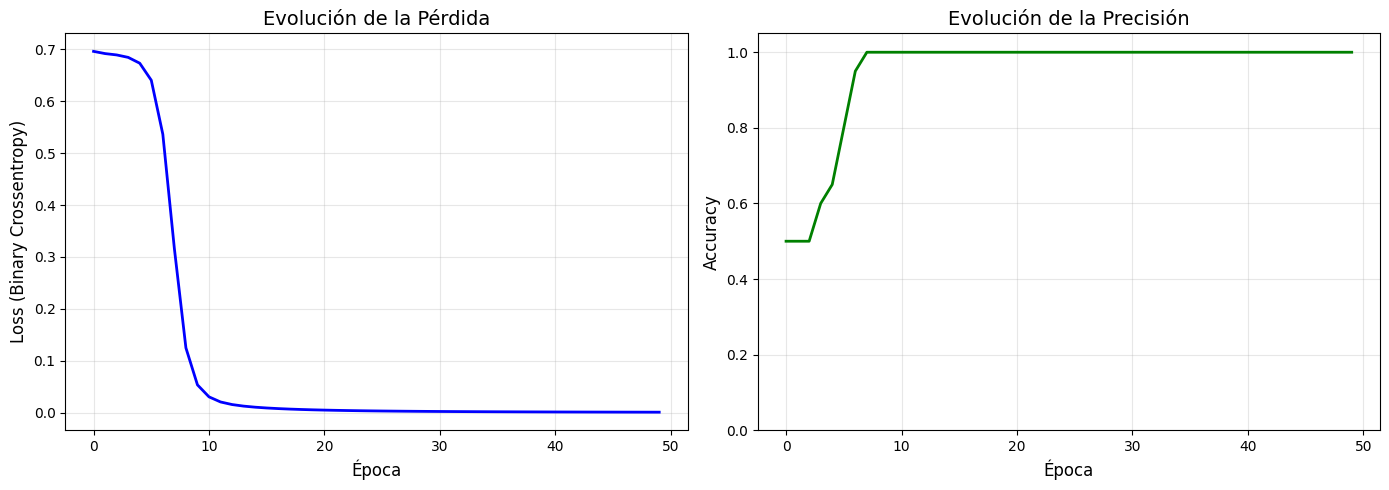

Interpretación de las curvas:
- Loss descendente: El modelo está aprendiendo
- Accuracy ascendente: Mejora en predicciones correctas
- Convergencia: Estabilización en valores finales

Nota: Con más datos, usaríamos un conjunto de validación
para detectar overfitting (train accuracy >> val accuracy).


In [8]:
# Extraemos historial de métricas
loss_history = historia.history['loss']
acc_history = historia.history['accuracy']

# Creamos figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Loss
ax1.plot(loss_history, linewidth=2, color='blue')
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss (Binary Crossentropy)', fontsize=12)
ax1.set_title('Evolución de la Pérdida', fontsize=14)
ax1.grid(True, alpha=0.3)

# Subplot 2: Accuracy
ax2.plot(acc_history, linewidth=2, color='green')
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Evolución de la Precisión', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])  # Fijamos rango [0, 1]

plt.tight_layout()
plt.show()

print("Interpretación de las curvas:")
print("=" * 70)
print("- Loss descendente: El modelo está aprendiendo")
print("- Accuracy ascendente: Mejora en predicciones correctas")
print("- Convergencia: Estabilización en valores finales")
print("\nNota: Con más datos, usaríamos un conjunto de validación")
print("para detectar overfitting (train accuracy >> val accuracy).")

---

## 11. Evaluación del Modelo

Evaluamos el modelo en el conjunto de entrenamiento y analizamos predicciones individuales.

In [9]:
# Obtenemos predicciones
# predict() retorna probabilidades (valores entre 0 y 1)
predicciones_prob = modelo.predict(X, verbose=0)

# Convertimos probabilidades a clases (umbral 0.5)
predicciones_clase = (predicciones_prob >= 0.5).astype(int).flatten()

# Calculamos accuracy manualmente
aciertos = np.sum(predicciones_clase == y)
total = len(y)
accuracy = aciertos / total

print("Evaluación en el conjunto de entrenamiento:")
print("=" * 70)

for i in range(len(frases)):
    prob = predicciones_prob[i][0]
    pred_clase = predicciones_clase[i]
    real_clase = int(y[i])

    correcto = "✓" if pred_clase == real_clase else "✗"
    sent_real = "Positivo" if real_clase == 1 else "Negativo"
    sent_pred = "Positivo" if pred_clase == 1 else "Negativo"

    # Truncamos frase si es muy larga
    frase_corta = frases[i] if len(frases[i]) <= 55 else frases[i][:52] + "..."

    print(f"\n{correcto} '{frase_corta}'")
    print(f"  Real: {sent_real} | Pred: {sent_pred} (prob={prob:.3f})")

print("\n" + "=" * 70)
print(f"Accuracy: {aciertos}/{total} = {accuracy:.2%}")

Evaluación en el conjunto de entrenamiento:

✓ 'La verdad, este lugar está bárbaro. Muy recomendable.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'Qué buena onda la atención, volvería sin dudarlo.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'Me encantó la comida, aunque la música estaba muy fu...'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'Todo excelente. Atención de diez.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'Muy conforme con el resultado final.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'Superó mis expectativas, gracias.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'El mejor asado que probé en mucho tiempo.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'Excelente relación precio-calidad, muy recomendable.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'La atención fue impecable, muy atentos.'
  Real: Positivo | Pred: Positivo (prob=0.999)

✓ 'Me gustó mucho el ambiente tranquilo.'
  Real: Positivo | Pred: Positivo (prob=0.999

---

## 12. Predicción sobre Frases Nuevas

Probamos el modelo con frases que nunca vio durante el entrenamiento.

In [10]:
# Frases de prueba
frases_prueba = [
    "No me gustó la atención, bastante mala y lenta.",
    "Muy buena experiencia, todo excelente y rápido.",
    "Una estafa total, no lo recomiendo para nada.",
    "Súper conforme con el servicio, muy atentos.",
    "Nada que ver con lo prometido, una decepción.",
    "La mejor atención que tuve en mucho tiempo.",
    "El lugar está bien pero la comida es mala.",
    "Aunque tardaron mucho, la comida estaba excelente."
]

# Preprocesamiento: texto → secuencias → padding
# Usamos el MISMO tokenizer y maxlen que en entrenamiento
secuencias_prueba = tokenizer.texts_to_sequences(frases_prueba)
X_prueba = pad_sequences(secuencias_prueba, maxlen=maxlen, padding='post')

# Predicciones
predicciones_prueba = modelo.predict(X_prueba, verbose=0)

# Mostramos resultados
print("Predicciones sobre frases nuevas:")
print("=" * 70)

for i, frase in enumerate(frases_prueba):
    prob = predicciones_prueba[i][0]
    clase = "POSITIVO" if prob >= 0.5 else "NEGATIVO"
    confianza = prob if prob >= 0.5 else (1 - prob)

    print(f"\nFrase: '{frase}'")
    print(f"Predicción: {clase}")
    print(f"Probabilidad positivo: {prob:.3f}")
    print(f"Confianza: {confianza:.1%}")

Predicciones sobre frases nuevas:

Frase: 'No me gustó la atención, bastante mala y lenta.'
Predicción: NEGATIVO
Probabilidad positivo: 0.001
Confianza: 99.9%

Frase: 'Muy buena experiencia, todo excelente y rápido.'
Predicción: POSITIVO
Probabilidad positivo: 0.999
Confianza: 99.9%

Frase: 'Una estafa total, no lo recomiendo para nada.'
Predicción: NEGATIVO
Probabilidad positivo: 0.001
Confianza: 99.9%

Frase: 'Súper conforme con el servicio, muy atentos.'
Predicción: POSITIVO
Probabilidad positivo: 0.999
Confianza: 99.9%

Frase: 'Nada que ver con lo prometido, una decepción.'
Predicción: NEGATIVO
Probabilidad positivo: 0.003
Confianza: 99.7%

Frase: 'La mejor atención que tuve en mucho tiempo.'
Predicción: POSITIVO
Probabilidad positivo: 0.999
Confianza: 99.9%

Frase: 'El lugar está bien pero la comida es mala.'
Predicción: POSITIVO
Probabilidad positivo: 0.999
Confianza: 99.9%

Frase: 'Aunque tardaron mucho, la comida estaba excelente.'
Predicción: POSITIVO
Probabilidad positivo: 0.

---

## 13. Inspección de Embeddings Aprendidos

Los embeddings aprendidos capturan similitud semántica. Veamos algunos ejemplos.

In [ ]:
# Extraemos los pesos de la capa Embedding
embedding_layer = modelo.get_layer('embedding')
embedding_weights = embedding_layer.get_weights()[0]  # Shape: (vocab_size, embedding_dim)

print(f"Matriz de embeddings: {embedding_weights.shape}")
print(f"Cada palabra tiene un vector de {embedding_dim} dimensiones.")

# Función para obtener embedding de una palabra
def get_embedding(palabra):
    idx = tokenizer.word_index.get(palabra.lower())
    if idx is None:
        return None
    return embedding_weights[idx]

# Función para calcular similitud coseno
def similitud_coseno(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Analizamos similitudes
print("\n" + "=" * 70)
print("Similitudes semánticas aprendidas:")
print("-" * 70)

pares = [
    ("excelente", "buena"),
    ("excelente", "mala"),
    ("atención", "servicio"),
    ("recomendable", "malísima"),
]

for palabra1, palabra2 in pares:
    emb1 = get_embedding(palabra1)
    emb2 = get_embedding(palabra2)

    if emb1 is not None and emb2 is not None:
        sim = similitud_coseno(emb1, emb2)
        print(f"Similitud('{palabra1}', '{palabra2}'): {sim:.3f}")
    else:
        palabras_faltantes = []
        if emb1 is None:
            palabras_faltantes.append(palabra1)
        if emb2 is None:
            palabras_faltantes.append(palabra2)
        print(f"Palabra(s) no en vocabulario: {', '.join(palabras_faltantes)}")

print("\nInterpretación:")
print("- Similitud cercana a 1: Palabras semánticamente similares")
print("- Similitud cercana a 0: Palabras no relacionadas")
print("- Similitud negativa: Palabras opuestas (ej: bueno/malo)")
print("\nNota: Con más datos, los embeddings capturarían relaciones más ricas.")

---

## 14. Guardar y Cargar el Modelo

Keras permite guardar modelos completos (arquitectura + pesos).

In [ ]:
# Guardar el modelo completo
# Formato .h5 (HDF5): Incluye arquitectura, pesos, optimizador
modelo.save('lstm_sentiment.h5')
print("Modelo guardado en: lstm_sentiment.h5")

# Cargar el modelo
from tensorflow.keras.models import load_model
modelo_cargado = load_model('lstm_sentiment.h5')
print("Modelo cargado exitosamente.")

# Verificamos que funciona igual
pred_original = modelo.predict(X_prueba, verbose=0)
pred_cargado = modelo_cargado.predict(X_prueba, verbose=0)

# Comprobamos que las predicciones son idénticas
igual = np.allclose(pred_original, pred_cargado)
print(f"\n¿Predicciones idénticas? {igual}")

print("\nEn producción, también necesitarías guardar el tokenizer:")
print("import pickle")
print("with open('tokenizer.pkl', 'wb') as f:")
print("    pickle.dump(tokenizer, f)")

---

## Guía Teórico-Conceptual

### 1. Comparación: RNN Simple vs. LSTM vs. GRU

| Característica | RNN Simple | LSTM | GRU |
|----------------|------------|------|-----|
| Parámetros | Pocos | Muchos | Moderados |
| Memoria a largo plazo | ❌ Vanishing gradient | ✓ Cell state | ✓ Reset/update gates |
| Complejidad | Baja | Alta | Media |
| Velocidad | Rápida | Lenta | Moderada |
| Uso moderno | Obsoleto | Estándar | Alternativa popular |

**GRU (Gated Recurrent Unit):**
- Versión simplificada de LSTM (menos parámetros)
- Combina forget e input gates en un solo "update gate"
- Más rápido de entrenar, rendimiento similar
- Popular en NLP cuando velocidad importa

### 2. Bidirectional LSTM

LSTM procesa secuencia en una dirección:
```
"No me gusta" → [No] → [me] → [gusta]
```

**Bidirectional LSTM** procesa en ambas direcciones:
```
Forward:  [No] → [me] → [gusta]
Backward: [gusta] → [me] → [No]
```

Luego concatena ambos hidden states.

**Ventaja:** Captura contexto antes y después de cada palabra

**Implementación en Keras:**
```python
from tensorflow.keras.layers import Bidirectional

modelo = Sequential([
    Embedding(...),
    Bidirectional(LSTM(32)),  # ← Bidirectional wrapper
    Dense(1, activation='sigmoid')
])
```

**Trade-off:** 2x parámetros, 2x tiempo de entrenamiento

### 3. Return Sequences vs. Return State

**return_sequences=False** (default):
```
Input:  (batch, timesteps, features)
Output: (batch, units)  # Solo hidden state final
```
Útil para clasificación (como en este notebook).

**return_sequences=True**:
```
Input:  (batch, timesteps, features)
Output: (batch, timesteps, units)  # Hidden state en cada timestep
```
Útil para:
- Apilar múltiples LSTMs
- Sequence-to-sequence (traducción)
- Token classification (NER)

**Ejemplo con múltiples LSTMs:**
```python
modelo = Sequential([
    Embedding(...),
    LSTM(64, return_sequences=True),  # Primera LSTM
    LSTM(32),                         # Segunda LSTM
    Dense(1, activation='sigmoid')
])
```

### 4. Embeddings: Aprendidos vs. Pre-entrenados

**¿Cuándo usar embeddings aprendidos?**
- Vocabulario específico del dominio
- Suficientes datos (>10k muestras)
- Tarea muy específica

**¿Cuándo usar pre-entrenados (Word2Vec, GloVe, FastText)?**
- Pocos datos (<1k muestras)
- Vocabulario general
- Transfer learning

**Implementación con pre-entrenados:**
```python
# 1. Cargar embeddings (ej: GloVe)
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# 2. Crear matriz de embeddings para nuestro vocabulario
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

# 3. Cargar en la capa Embedding
embedding_layer = Embedding(
    vocab_size,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False  # Congelar embeddings
)
```

### 5. Limitaciones de LSTM

**1. Procesamiento secuencial:**
- No se puede paralelizar (cada paso necesita el anterior)
- Lento en secuencias largas

**2. Dependencias realmente largas:**
- Aunque mejor que RNN simple, LSTM sigue olvidando en textos muy largos (>1000 tokens)

**3. Desbalance de información:**
- Palabras al final influyen más que al inicio
- Bidirectional LSTM mitiga esto

**4. Interpretabilidad:**
- Hidden state es una "caja negra"
- Difícil saber qué información retiene

**Solución moderna: Transformers**
- Attention mechanism: Todas las palabras se ven entre sí
- Paralelizable: Mucho más rápido
- Mejor captura de dependencias largas
- Esto lo veremos en el próximo notebook (BERT, GPT)

### 6. Técnicas para Prevenir Overfitting

**Dropout:**
```python
LSTM(32, dropout=0.2, recurrent_dropout=0.2)
```
- `dropout`: Apaga aleatoriamente inputs
- `recurrent_dropout`: Apaga conexiones recurrentes

**Regularización L2:**
```python
from tensorflow.keras.regularizers import l2

LSTM(32, kernel_regularizer=l2(0.01))
```

**Early Stopping:**
```python
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)
modelo.fit(..., validation_data=(X_val, y_val), callbacks=[early_stop])
```

**Data Augmentation para texto:**
- Sinónimos (usando WordNet)
- Back-translation (traducir y volver a traducir)
- Random insertion/deletion/swap de palabras

### 7. Sequence-to-Sequence (Seq2Seq)

Para tareas como traducción, necesitamos **encoder-decoder**:

```
Encoder LSTM: "Hello" → hidden state h
Decoder LSTM: h → "Hola"
```

**Implementación básica:**
```python
# Encoder
encoder = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
```

**Attention mechanism:** Mejora crucial (base de Transformers)

---

## Preguntas y Respuestas para Estudio

### Preguntas Conceptuales

**1. ¿Por qué LSTM resuelve el problema de vanishing gradient?**

*Respuesta:* LSTM usa un **cell state** que fluye directamente a través de los timesteps con suma (no multiplicación). Las compuertas controlan qué agregar/remover del cell state, pero los gradientes fluyen sin multiplicarse repetidamente por matrices de pesos, evitando que se desvanezcan.

**2. ¿Qué hace cada compuerta (gate) en una LSTM?**

*Respuesta:*
- **Forget gate**: Decide qué información del cell state anterior descartar (qué olvidar)
- **Input gate**: Decide qué nueva información agregar al cell state
- **Output gate**: Decide qué parte del cell state exponer como hidden state

Cada una aprende cuándo activarse basándose en el input actual y el hidden state anterior.

**3. ¿Por qué necesitamos padding? ¿Qué problema resuelve?**

*Respuesta:* Las redes neuronales requieren inputs de tamaño fijo, pero las frases tienen longitudes variables. Padding rellena secuencias cortas con ceros para que todas tengan la misma longitud. Esto permite procesarlas en batches eficientemente.

**4. ¿Cuál es la diferencia fundamental entre Bag of Words y procesamiento secuencial?**

*Respuesta:*
- **BoW**: Ignora orden, solo cuenta ocurrencias. "No me gusta" = "Me gusta no"
- **Secuencial (LSTM)**: Procesa palabra por palabra en orden. Captura que "no" antes de "me gusta" invierte el sentimiento

**5. ¿Qué aprende la capa Embedding?**

*Respuesta:* Aprende representaciones vectoriales densas de palabras donde palabras con significados similares tienen vectores cercanos en el espacio de embeddings. Durante el entrenamiento, ajusta estos vectores para que sean útiles para la tarea específica (en nuestro caso, clasificación de sentimientos).

### Preguntas Técnicas

**6. En el código, ¿por qué vocab_size = len(tokenizer.word_index) + 1?**

*Respuesta:* El +1 es porque Keras reserva el índice 0 para padding. El tokenizer asigna índices desde 1 en adelante a las palabras. Entonces si tenemos 100 palabras únicas, word_index va de 1 a 100, y necesitamos 101 posiciones (0-100) en la capa Embedding.

**7. ¿Qué pasa si una palabra nueva (no en el vocabulario) aparece en producción?**

*Respuesta:* El tokenizer la reemplaza por el token OOV (Out Of Vocabulary) que configuramos con `oov_token="<OOV>"`. Este token tiene su propio embedding aprendido que representa "palabra desconocida". Es importante incluir el oov_token durante entrenamiento para que el modelo aprenda a manejarlo.

**8. ¿Por qué LSTM devuelve solo el hidden state final y no todos?**

*Respuesta:* Porque `return_sequences=False` (default). Para clasificación, solo necesitamos la representación final que "resume" toda la secuencia. Si configuramos `return_sequences=True`, devolvería el hidden state en cada timestep, útil para apilar LSTMs o tareas como NER donde necesitamos clasificar cada token.

**9. En la capa Embedding, ¿qué significan los parámetros input_dim, output_dim, input_length?**

*Respuesta:*
- `input_dim`: Tamaño del vocabulario (cuántas palabras diferentes puede manejar)
- `output_dim`: Dimensión del vector de embedding (ej: 16, 100, 300)
- `input_length`: Longitud de las secuencias de entrada (después del padding)

**10. ¿Qué hace padding='post' vs. padding='pre'?**

*Respuesta:*
- `padding='post'`: Agrega ceros al **final**: [5, 2, 8, 0, 0, 0]
- `padding='pre'`: Agrega ceros al **inicio**: [0, 0, 0, 5, 2, 8]

Para LSTM, `post` suele ser mejor porque las palabras relevantes quedan al principio de la secuencia (donde la LSTM tiene mejor memoria).

### Preguntas de Aplicación

**11. Si tuvieras un dataset de 50,000 reseñas, ¿qué cambios harías al código?**

*Respuesta:*
1. **Train/val/test split**: 70/15/15 para evaluación honesta
2. **Batch size mayor**: 32 o 64 (más eficiente)
3. **Validation en fit()**: Monitorear overfitting
4. **Early stopping**: Callback para detener si val_loss no mejora
5. **Modelo más grande**: embedding_dim=100, lstm_units=128
6. **Dropout**: Para regularización
7. **Learning rate scheduling**: Reducir lr gradualmente

**12. ¿Cómo implementarías un modelo Seq2Seq para traducción español→inglés?**

*Respuesta:*
```python
# Encoder: Procesa español
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(vocab_size_es, 256)(encoder_inputs)
encoder_lstm = LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder: Genera inglés
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(vocab_size_en, 256)(decoder_inputs)
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(
    decoder_embedding,
    initial_state=encoder_states  # ← Contexto del encoder
)
decoder_dense = Dense(vocab_size_en, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
```

**13. ¿Cómo cargarías embeddings pre-entrenados de Word2Vec en este modelo?**

*Respuesta:*
```python
from gensim.models import KeyedVectors

# 1. Cargar Word2Vec
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors.bin', binary=True)

# 2. Crear matriz de embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if word in w2v:
        embedding_matrix[idx] = w2v[word]

# 3. Configurar capa Embedding
Embedding(
    vocab_size,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False  # Congelar o permitir fine-tuning
)
```

**14. Si el modelo predice siempre la misma clase, ¿qué revisarías?**

*Respuesta:*
1. **Dataset desbalanceado**: Verificar distribución de clases
2. **Learning rate muy alto**: Probablemente divergió
3. **Inicialización de pesos**: Revisar si hay NaNs
4. **Preprocesamiento incorrecto**: ¿El tokenizer se aplicó bien?
5. **Loss function incorrecta**: Verificar que es binary_crossentropy
6. **Modelo muy simple**: Aumentar capacidad (más unidades)

**15. Diseñá una arquitectura LSTM profunda con 3 capas LSTM apiladas.**

*Respuesta:*
```python
modelo = Sequential([
    Embedding(vocab_size, 64, input_length=maxlen),
    
    # LSTM 1: return_sequences=True para alimentar siguiente LSTM
    LSTM(128, return_sequences=True, dropout=0.2),
    
    # LSTM 2: También return_sequences=True
    LSTM(64, return_sequences=True, dropout=0.2),
    
    # LSTM 3: return_sequences=False (solo hidden state final)
    LSTM(32, dropout=0.2),
    
    # Clasificación
    Dense(1, activation='sigmoid')
])
```
**Trade-off:** Más parámetros = más capacidad pero más riesgo de overfitting.

---

## Ejercicios Propuestos

### Ejercicio 1: Bidirectional LSTM
Modificá el modelo para usar `Bidirectional(LSTM(...))`. Compará:
- Tiempo de entrenamiento
- Accuracy final
- Número de parámetros

### Ejercicio 2: LSTM Profunda
Apilá 2-3 capas LSTM. Recordá usar `return_sequences=True` en todas menos la última. ¿Mejora el rendimiento?

### Ejercicio 3: GRU vs. LSTM
Reemplazá `LSTM` por `GRU` (misma sintaxis). Compará:
- Velocidad de entrenamiento
- Accuracy
- Número de parámetros

### Ejercicio 4: Embeddings Pre-entrenados
Cargá embeddings de FastText o Word2Vec y usálos en lugar de embeddings aprendidos. ¿El modelo converge más rápido?

### Ejercicio 5: Análisis de Errores
Identificá las frases que el modelo clasifica incorrectamente. ¿Hay patrones comunes? (ej: negaciones, ironía, frases ambiguas)

---

## Conclusión

En este notebook dimos el salto de modelos feedforward a **procesamiento secuencial**. Aprendimos:

1. **Arquitectura LSTM**: Celdas de memoria, compuertas, manejo de dependencias largas
2. **Procesamiento de texto como secuencia**: Tokenización, padding, embeddings
3. **Keras API**: Sequential, fit, callbacks, guardar/cargar modelos
4. **Embeddings aprendidos**: Representaciones densas específicas de la tarea
5. **Comparación con MLP**: Ventajas de capturar orden temporal

### Limitaciones de LSTM

Aunque LSTM es poderosa, tiene restricciones:
- **Procesamiento secuencial**: No paralelizable, lento en secuencias largas
- **Dependencias muy largas**: Aún tiene límites (mejor que RNN, pero no perfecto)
- **Caja negra**: Difícil interpretar qué recuerda

### ¿Qué sigue?

En el próximo notebook exploraremos **Transformers con HuggingFace**, la arquitectura que revolucionó NLP:
- **Attention mechanism**: Todas las palabras se ven entre sí
- **Paralelización**: Mucho más rápido que LSTM
- **Transfer learning**: Modelos pre-entrenados (BETO, RoBERTa)
- **Estado del arte**: BERT, GPT, T5

Los transformers resolvieron las limitaciones de LSTM y dominan NLP moderno. Esto será el puente hacia el programa principal de tu curso.

---

*Este material fue desarrollado con fines educativos para la Tecnicatura en Ciencia de Datos del IFTS.*